#### notebooks/03_Clustering_Analysis.ipynb

In [33]:

# Import Libraries
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import folium
from folium.plugins import MarkerCluster

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import from the src modules
from src.config import *
#from src.config import SKILLS_LIST, JOB_CATEGORIES, CLUSTER_COLORS
from src.visualize import create_elbow_plot, create_pca_plot, create_cluster_map, plot_cluster_profiles


In [34]:
#Load the Cleaned Data
clean_data_path = os.path.join(project_root, 'data', 'processed', 'jobs_clean.csv')
df = pd.read_csv(clean_data_path)

print(f"Data shape: {df.shape}")


Data shape: (1783, 12)


In [35]:
print("Columns in the DataFrame:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head(2)

Columns in the DataFrame:
['title', 'description', 'salary_min', 'salary_max', 'latitude', 'longitude', 'salary_mid', 'country', 'region', 'county', 'city', 'skills_extracted']

First few rows:


,title,description,salary_min,salary_max,latitude,longitude,salary_mid,country,region,county,city,skills_extracted
0,Data Engineer,"At NTT DATA, we know that with the right people on board, anything is possible. The quality, integrity, and commitment of our employees are key factors in our company’s growth, market presence and our ability to help our clients stay a step ahead of the competition. By hiring the best people and helping them grow both professionally and personally, we ensure a bright future for NTT DATA and for the people who work here. NTT DATA is currently looking for a Data Engineer for our growing team in t…",60358.53,60358.53,55.86026,-4.25596,60358.53,UK,Scotland,Glasgow,Unknown,general tech skills
1,Senior Data Analyst,"Competitive salary | UK/Glasgow: hybrid working model (2-3 days on site) At NTT DATA, we know that with the right people on board, anything is possible. The quality, integrity, and commitment of our employees are key factors in our company’s growth, market presence and our ability to help our clients stay a step ahead of the competition. By hiring the best people and helping them grow both professionally and personally, we ensure a bright future for NTT DATA and for the people who work here. NT…",72252.80,72252.80,55.86026,-4.25596,72252.80,UK,Scotland,Glasgow,Unknown,general tech skills


In [36]:
# Prepare numerical features (salary and location)
numerical_features = df[['salary_mid', 'latitude', 'longitude']].copy()

In [37]:
df['skills_extracted'].value_counts().head(20)

skills_extracted
general skills                             385
general tech skills                        366
general healthcare skills                  289
ai                                         105
healthcare                                  90
clinical                                    81
nursing                                     61
artificial intelligence ai data science     31
artificial intelligence                     29
medical                                     24
nursing healthcare                          21
nursing clinical                            19
cloud                                       18
machine learning                            11
patient care healthcare                     10
medication clinical                         10
patient care                                 9
ai cloud                                     9
communication clinical                       8
automation ai                                7
Name: count, dtype: int64

In [38]:
# Display a random sample of 10 rows to verify new features
df.sample(10)

,title,description,salary_min,salary_max,latitude,longitude,salary_mid,country,region,county,city,skills_extracted
1515,Lead Veterinary Surgeon – Ashford,"Lead Veterinary Surgeon – Ashford About the role We’re hiring a Lead Veterinary Surgeon to join a well-equipped first‑opinion small‑animal practice in Ashford . You’ll see a varied caseload with the scope to shape the diary around your strengths. What you’ll be doing Deliver high‑quality consultations and routine surgery Work cases up with digital x‑ray, ultrasound and in‑house lab Collaborate with a capable nursing and client care team Contribute to clinical discussions and protocol improvemen…",41791.56,41791.56,51.148399,0.875563,41791.56,UK,South East England,Kent,Ashford,nursing clinical
1439,Registered Nursing Home Manager,"An outstanding new job opportunity has arisen for an experienced Home Manager to manage an exceptional nursing home based in the Bedford, Bedfordshire area. You will be working for one of UK's leading health care providers This is one of the latest nursing homes in the heart of Bedford which will provide an intimate, relaxed abode for care seekers demanding the luxurious features of a five-star boutique hotel To be considered for this position you must hold an active NMC Pin and experience in m…",0.00,60000.00,52.144939,-0.481848,30000.00,UK,Eastern England,Bedfordshire,Bedford,nursing
1466,Nurse Assessor,"Nurse Assessor – Hybrid Role (Chelmsford – WCA Assessments) Location: Chelmsford, Essex (Hybrid: 2 days remote, 3 days on-site) Salary: £39,500 per annum Job Type: Full-time | Schedule: Monday to Friday, 9:00am – 5:30pm Looking to leave shift work behind while still making a clinical impact? We’re looking for experienced Registered Nurses to join our client’s team in Chelmsford as a Nurse Assessor , conducting Work Capability Assessments (WCA) on behalf of the Department for Work and Pensions (…",39500.00,39500.00,51.735802,0.469708,39500.00,UK,Eastern England,Essex,Chelmsford,clinical
1703,Operating Department Practitioner (ODP),"Exciting Opportunity for an Anaesthetics nurse - Band 5 at Spire Manchester Hospital. Medicspro are seeking experienced Anaesthetics nurse - Band 5 with recent NHS or private sector experience, who are looking for flexible adhoc or full time agency/locum work at Spire Manchester. This opportunity is to cover Monday to Saturday, Day shifts working various hours shifts. Key responsibilities - Conducting patient consultations. -Provide Primary support to the patient and the Anaesthetist throughout…",60320.00,68640.00,53.480701,-2.234380,64480.00,UK,North West England,Greater Manchester,Manchester,general skills
1307,Home Manager,"An outstanding new job opportunity has arisen for a dedicated Home Manager to manage an exceptional care home based in the Newtownabbey, Northern Ireland area. You will be working for one of UK's leading healthcare providers This is a decorated purpose built care home which has an excellent care team and provides 24-hour nursing care, and respite care To be considered for this position you must be qualified as a Registered Nurse with a current active NMC Pin As a Home Manager your key responsib…",0.00,53000.00,54.670459,-5.913449,26500.00,UK,Northern Ireland,County Antrim,Newtownabbey,nursing healthcare
1652,Female Personal Trainer - Liverpool,"Empowered to Succeed: A Personal Training Career Built for You Ultimate Performance (UP) is a global leading Personal Training Gym that provides 1-2-1 laser precision and highly technical training initiatives on an individual basis to clients. We go beyond workouts, this is personalised coaching built entirely around our clients. From day one, we design a bespoke training and nutrition plan based on goals, lifestyle, and training history. We're opening up our next intake of outstanding personal…",25500.00,25500.00,53.410801,-2.977840,25500.00,UK,North West England,Merseyside,Liverpool,general skills
1086,Care Assistant,"Job Description We are seeking a compa

In [39]:
#Prepare text features (skills)
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
skills_tfidf = vectorizer.fit_transform(df['skills_extracted'])
skills_df = pd.DataFrame(skills_tfidf.toarray(), 
                        columns=vectorizer.get_feature_names_out())

print("Top skills identified:")
print(skills_df.sum().sort_values(ascending=False).head(20))

Top skills identified:
skills           576.096986
general          576.096986
healthcare       329.347355
tech             279.832931
ai               153.029386
clinical         115.157128
nursing          102.190785
cloud             44.807344
intelligence      40.219900
artificial        40.219900
medical           39.921451
data              31.501213
science           27.033608
azure             24.837555
learning          23.749586
machine           22.668890
patient           20.515364
care              19.733162
automation        18.580935
communication     16.368578
dtype: float64


##### Feature Scaling and Combination

In [40]:
# Scale numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(numerical_features)

# Combine all features
X = np.concatenate([scaled_numerical, skills_df.values], axis=1)

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (1783, 53)


##### Determining Optimal K for K-Means


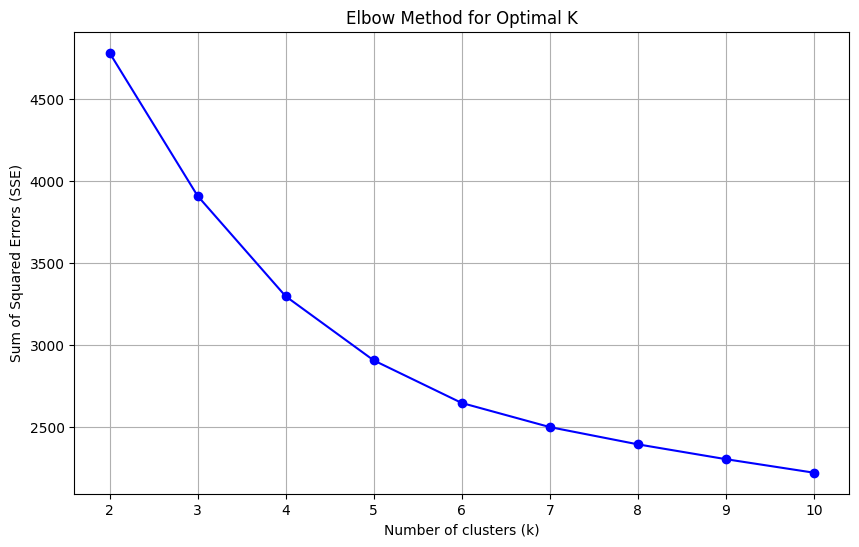

For k=2, silhouette score: 0.286
For k=3, silhouette score: 0.294
For k=4, silhouette score: 0.259
For k=5, silhouette score: 0.264
For k=6, silhouette score: 0.216
For k=7, silhouette score: 0.202
For k=8, silhouette score: 0.200
For k=9, silhouette score: 0.188
For k=10, silhouette score: 0.191


In [41]:
# Elbow method to find optimal cluster count
sse = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.savefig('../reports/figures/elbow_plot.png')
plt.show()

# Also check silhouette scores
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}, silhouette score: {silhouette_avg:.3f}")

# Choose optimal k (you decide based on elbow and silhouette)
optimal_k = 4  # Example - you might choose differently


In [42]:
# Apply K-Means Clustering

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X)

# Analyze clusters
cluster_profile = df.groupby('cluster_kmeans').agg({
    'salary_mid': 'mean',
    'title': 'count',
    'region': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).rename(columns={'title': 'count', 'salary_mid': 'avg_salary'})

print("K-Means Cluster Profiles:")
print(cluster_profile)

K-Means Cluster Profiles:
                   avg_salary  count              region
cluster_kmeans                                          
0                46671.809685    699  North West England
1                49479.829072    830              London
2                53999.153636    154            Scotland
3               151948.289400    100              London


In [43]:
# 7. Applying DBSCAN for Niche Role Detection

#dbscan = DBSCAN(eps=0.5, min_samples=5) # gives 639 potential niche roles
#dbscan = DBSCAN(eps=0.8, min_samples=3) # 189 potential niche roles
#dbscan = DBSCAN(eps=1.0, min_samples=5)   # 171 potential niche roles
#dbscan = DBSCAN(eps=1.2, min_samples=10)  # 107 potential niche roles
dbscan = DBSCAN(eps=1.5, min_samples=5)  # 107 potential niche roles
df['cluster_dbscan'] = dbscan.fit_predict(X)

# Identify niche roles (outliers)
niche_jobs = df[df['cluster_dbscan'] == -1]
print(f"Found {len(niche_jobs)} potential niche roles")

# Analyze niche roles
print("\nSample niche roles:")
display(niche_jobs[['title', 'salary_mid', 'skills_extracted']].head(10))

Found 15 potential niche roles

Sample niche roles:


,title,salary_mid,skills_extracted
55,Data Architect,172640.0,data analysis machine learning
212,Lead Data Science Consultant,169000.0,ai data science azure
432,Data Engineer,270000.0,general tech skills
718,VP - AI/ML & Data,150000.0,automation ai
811,"Manager of Product Engineering, Applied AI",282500.0,general tech skills
957,(URGENT) Associate Dentist (Jersey) Relocation Package up to Â£15K,200000.0,general skills
1013,Consultant Psychiatrist - Eating Disorder Unit (EDU),170000.0,medical clinical healthcare
1092,(URGENT) Overseas Associate Dentist or Associate Dentist (Llanidloes),200000.0,clinical
1181,Child and Adolescent Psychiatrist - Auckland Community Psychiatry,275000.0,clinical
1286,(URGENT) Overseas Associate Dentist or Associate Dentist (Welshpool),200000.0,clinical


In [44]:
# Check the distribution of cluster sizes
cluster_counts = df['cluster_dbscan'].value_counts().sort_index()
print("DBSCAN Cluster Distribution:")
print(cluster_counts)

# Check average skills per cluster
skills_per_cluster = df.groupby('cluster_dbscan')['skills_extracted'].apply(
    lambda x: x.str.split().str.len().mean()
)
print("\nAverage skills per cluster:")
print(skills_per_cluster)

DBSCAN Cluster Distribution:
cluster_dbscan
-1      15
 0    1768
Name: count, dtype: int64

Average skills per cluster:
cluster_dbscan
-1    2.20000
 0    2.34276
Name: skills_extracted, dtype: float64


In [45]:
for cluster_id in sorted(df['cluster_dbscan'].unique()):
    cluster_data = df[df['cluster_dbscan'] == cluster_id]
    print(f"\n--- Cluster {cluster_id} ({len(cluster_data)} jobs) ---")
    print(f"Avg Salary: £{cluster_data['salary_mid'].mean():.0f}")
    print(f"Top Skills: {cluster_data['skills_extracted'].str.cat(sep=' ')}")
    print(f"Sample Titles: {cluster_data['title'].head(3).tolist()}")


--- Cluster -1 (15 jobs) ---
Avg Salary: £220543
Top Skills: data analysis machine learning ai data science azure general tech skills automation ai general tech skills general skills medical clinical healthcare clinical clinical clinical general skills general skills clinical healthcare general healthcare skills
Sample Titles: ['Data Architect', 'Lead Data Science Consultant', 'Data Engineer']

--- Cluster 0 (1768 jobs) ---
Avg Salary: £53108
Top Skills: general tech skills general tech skills general skills general tech skills general skills general skills general tech skills aws general tech skills general tech skills general tech skills general tech skills general tech skills general tech skills general tech skills general tech skills general tech skills cloud general tech skills general skills general skills general skills healthcare artificial intelligence ai data science cloud cloud general tech skills general skills general tech skills azure cloud general tech skills general sk

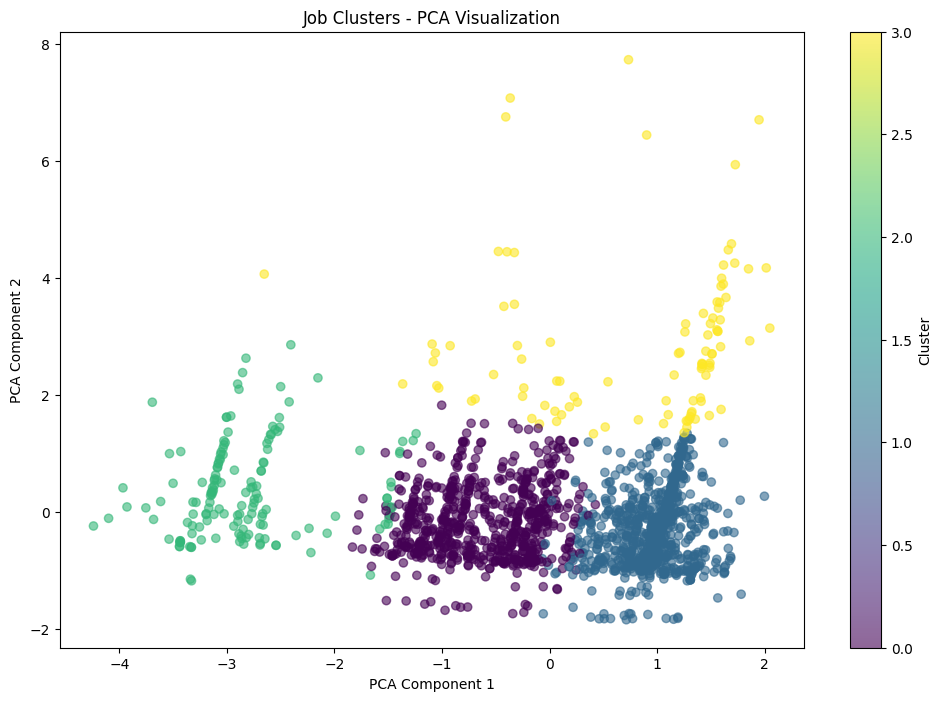

In [46]:
# Visualize Results with PCA (updated to use our function)
create_pca_plot(X, df['cluster_kmeans'], save_path='../reports/figures/pca_clusters.png')

In [47]:
# Create Geographic Cluster Map from config settings
cluster_map = create_cluster_map(
    df, 
    center=UK_CENTER, 
    zoom=MAP_ZOOM, 
    colors=CLUSTER_COLORS,
    save_path='../reports/job_clusters_map.html'
)


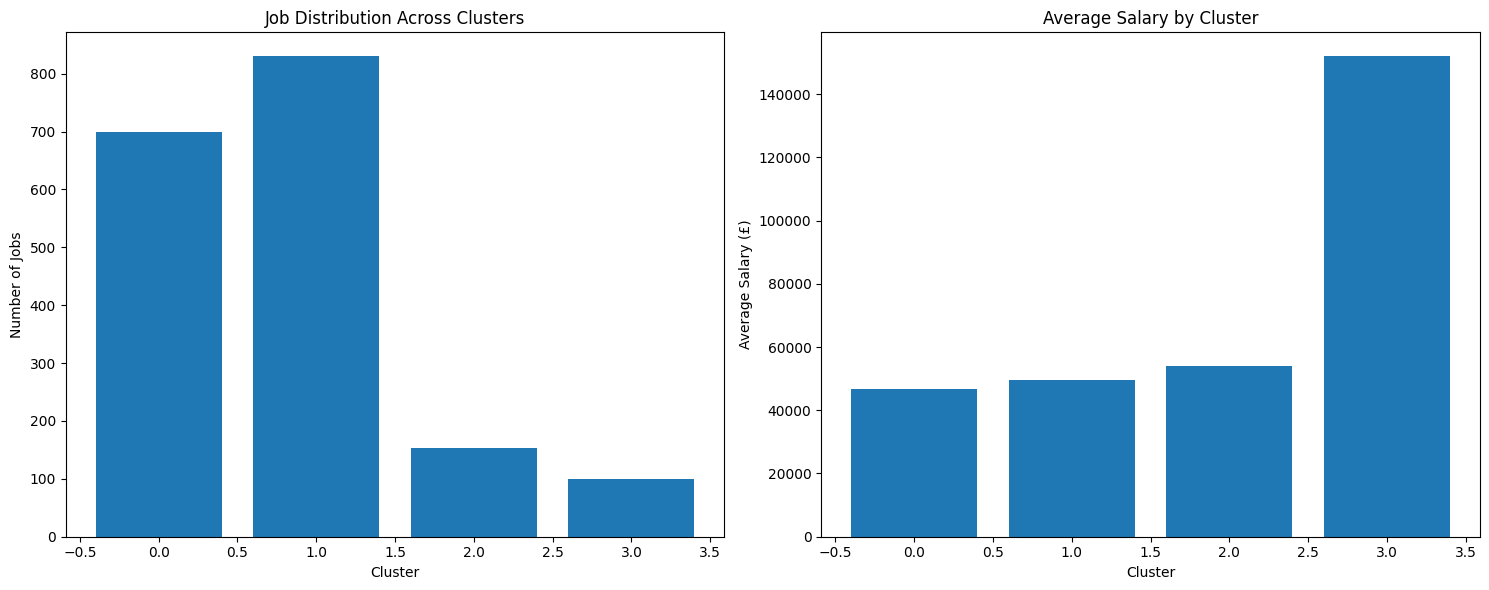

In [48]:
#Plot cluster profiles (new)
cluster_profile = df.groupby('cluster_kmeans').agg({
    'salary_mid': 'mean',
    'title': 'count',
    'region': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).rename(columns={'title': 'count', 'salary_mid': 'avg_salary'})

plot_cluster_profiles(cluster_profile, save_path='../reports/figures/cluster_profiles.png')

In [49]:
# Displaying a random sample of 5 rows, including clusters
df.sample(5)

,title,description,salary_min,salary_max,latitude,longitude,salary_mid,country,region,county,city,skills_extracted,cluster_kmeans,cluster_dbscan
1075,Mental Health - Healthcare Assistant (Temp),"We are recruiting for part-time and full-time Mental Health Care Assistants with hospital secure unit experience., If you have a PMVA and experience in this field then we have lots of vacancies for you. Carestaff Solutions are looking for passionate HCA’s to join our specialist mental health recruitment team. Our consultants work with the NHS, Private and Third Sector organisations across the UK, so whether you are looking for top up hours around another job, contract work or long term and perm…",25896.00,28080.00,53.747171,-2.707701,26988.00,UK,North West England,Lancashire,Preston,general healthcare skills,0,0
401,Data Engineer,"Trafalgar Talent is recruiting on behalf of a dynamic, subscription-based technology company looking to deepen its analytics capability. We're seeking a skilled and self-motivated Data Engineer to develop and manage their data infrastructure and help deliver actionable insights across the business using modern data warehousing and BI tools. The successful candidate will build robust ETL pipelines, shape BigQuery-based data warehouses, and deliver compelling Looker dashboards. If you're passiona…",60000.00,60000.00,50.851501,-1.179020,60000.00,UK,South East England,Hampshire,Fareham,etl,1,0
970,Care Assistant,"Job Description What you’ll do We are looking for caring, reliable, and flexible individuals to support an inspiring woman with a spinal cord injury who lives life to the fullest as a full-time wheelchair user. Care assistants enjoy a varied role, including holiday support, and a love of animals is a plus. No prior qualifications or experience needed as comprehensive training, shift shadowing, and ongoing team support are provided.",31434.74,31434.74,51.067402,-1.797630,31434.74,UK,South West England,Wiltshire,Salisbury,general healthcare skills,1,0
512,AI Engineerm- SC Cleared,"Morgan Hunt are working with a public sector client on two separate AI engineer roles. The first role is focused around Azure, and the second around Copilot. Key Criteria: Proven extensive experience developing AI solutions on Microsoft Azure AI Foundry, Microsoft Azure ML Studio or using Copilot . Understanding of data science concepts, AI / ML models, automation workflows, and agentic orchestration to enhance business processes. Experience designing and deploying Agentic AI solutions leveragi…",0.00,700.00,55.860260,-4.255960,350.00,UK,Scotland,Glasgow,Unknown,automation ai data science azure,2,0
664,AI Business Analyst,"WSD is looking to hire an eager and talented person to fill the role of a Technical Business Analyst. As WSD’s Technical Business Analyst in the AI Team, you will work with WSD’s dedicated AI development and data teams to push WSD to be the worldwide market leader in AI within the structured finance industry. WSD has recently undergone significant investment – in both personnel and hardware – to enable AI within every aspect of the business. In this role, you will combine the traditional role o…",32686.81,32686.81,51.502552,-0.019367,32686.81,UK,London,East London,Poplar,ai,1,0
